In [5]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [7]:
# Extract dataset
import os 

print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [8]:
from sklearn.model_selection import train_test_split

# Import dataset
features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

# X = features
# y = labels

# Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


### Step 1: Reduce dimensions of array using Three Tuple Algorithm (Ftt)

- Can try using convolution layer
- Can try use three tuple algorithm method (May be useful only for sparse matrices)

### Step 2: Perform clustering using K-Means (K-Means Cluster)

- Method 1: PCA / t-SNE
- Method 2: Take averages
- Method 4: Flatten the array

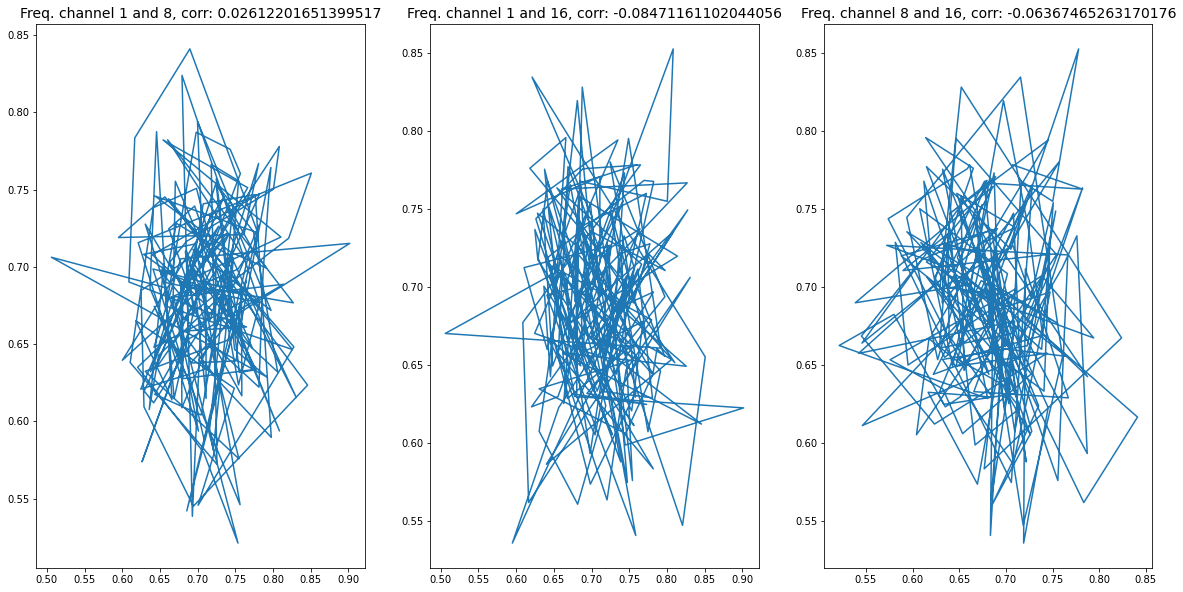

In [16]:
import matplotlib.pyplot as plt

# First, see if the data is linear or not
# Retrieve values from two frequency channels from the same sample over 
# multiple samples and do a scatterplot
# Find out correlation as well

# Retrieve the first feature
sample_feature = X[0]

# Retrieve measurements from the freq channel 1, 8 and 16
freqchannel1 = sample_feature[:,0]
freqchannel2 = sample_feature[:,7]
freqchannel3 = sample_feature[:,15]

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].set_title(f'Freq. channel 1 and 8, corr: {np.corrcoef(freqchannel1, freqchannel2)[0,1]}', fontsize = 14)
axs[0].plot(freqchannel1, freqchannel2)

axs[1].set_title(f'Freq. channel 1 and 16, corr: {np.corrcoef(freqchannel1, freqchannel3)[0,1]}', fontsize = 14)
axs[1].plot(freqchannel1, freqchannel3)

axs[2].set_title(f'Freq. channel 8 and 16, corr: {np.corrcoef(freqchannel2, freqchannel3)[0,1]}', fontsize = 14)
axs[2].plot(freqchannel2, freqchannel3)

In [28]:
# As data across different samples are taken at different time intervals, makes
# sense to average the value out
# Reduce each feature from shape of (193, 16) --> (1, 16)

channel_avgs = []

for feature in features:  
    channel_avgs.append(np.mean(feature, axis = 0))

reduced_dims_features = np.array(channel_avgs)
print(reduced_dims_features.shape)

(89628, 16)


In [38]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

inertias, distortions = [], []
inertias_mapping, distortions_mapping = {}, {}
K = range(1, 20)

for k in K:
    
    # Build and fit the model
    kmeanModel = KMeans(n_clusters = k).fit(reduced_dims_features)
    kmeanModel.fit(reduced_dims_features)
    
    distortions.append(sum(np.min(cdist(reduced_dims_features, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / reduced_dims_features.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    inertias_mapping[k] = sum(np.min(cdist(reduced_dims_features, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / reduced_dims_features.shape[0]
    distortions_mapping[k] = kmeanModel.inertia_

#### Metrics used:

- Distortion: Average of the squared distances from the cluster centers of the respective clusters to each data point (Euclidean distance metric)

- Inertia: Average sum of squared distances of samples to their closest cluster centre

In [39]:
for key,val in inertias_mapping.items():
    print(f'No. of clusters: {key}, inertias: {val}')

No. of clusters: 1, inertias: 0.5362975315872995
No. of clusters: 2, inertias: 0.4750671582532999
No. of clusters: 3, inertias: 0.43217634284113093
No. of clusters: 4, inertias: 0.39995080533026905
No. of clusters: 5, inertias: 0.3621357551311574
No. of clusters: 6, inertias: 0.33260222299629383
No. of clusters: 7, inertias: 0.31975716279216165
No. of clusters: 8, inertias: 0.3075477829708367
No. of clusters: 9, inertias: 0.2965881760317791
No. of clusters: 10, inertias: 0.2885760689921425
No. of clusters: 11, inertias: 0.28127851631829576
No. of clusters: 12, inertias: 0.2748831141704266
No. of clusters: 13, inertias: 0.2690859791809517
No. of clusters: 14, inertias: 0.2647138913198869
No. of clusters: 15, inertias: 0.25978182604004124
No. of clusters: 16, inertias: 0.2565609788940745
No. of clusters: 17, inertias: 0.25198061721391357
No. of clusters: 18, inertias: 0.25001669545462013
No. of clusters: 19, inertias: 0.24565256268599875


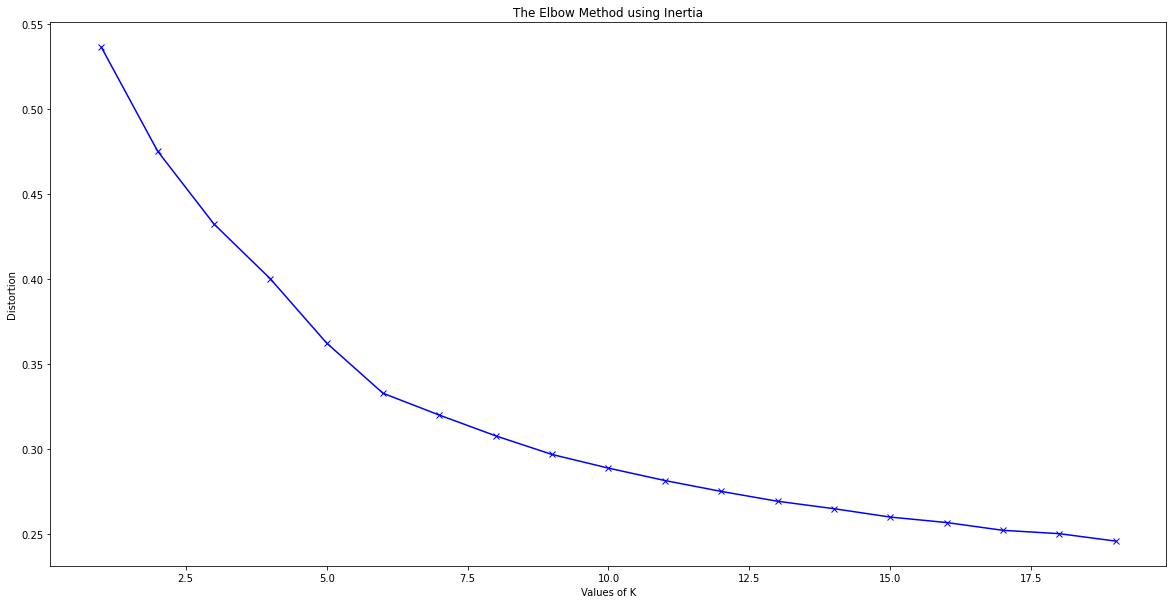

In [40]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Inertia')
plt.show()

In [41]:
for key,val in distortions_mapping.items():
    print(f'No. of clusters: {key}, distortion: {val}')

No. of clusters: 1, distortion: 27293.983573598347
No. of clusters: 2, distortion: 21761.70919531616
No. of clusters: 3, distortion: 18048.412942188403
No. of clusters: 4, distortion: 15247.605240486386
No. of clusters: 5, distortion: 12688.051747426136
No. of clusters: 6, distortion: 10790.85801124778
No. of clusters: 7, distortion: 9956.345120324084
No. of clusters: 8, distortion: 9193.523536005187
No. of clusters: 9, distortion: 8506.784220703172
No. of clusters: 10, distortion: 8054.217536420375
No. of clusters: 11, distortion: 7626.813752019315
No. of clusters: 12, distortion: 7280.642687808064
No. of clusters: 13, distortion: 6992.6485086245175
No. of clusters: 14, distortion: 6743.944947754808
No. of clusters: 15, distortion: 6527.103488638971
No. of clusters: 16, distortion: 6345.224183557418
No. of clusters: 17, distortion: 6141.266048298765
No. of clusters: 18, distortion: 6023.11882404382
No. of clusters: 19, distortion: 5838.464783761962


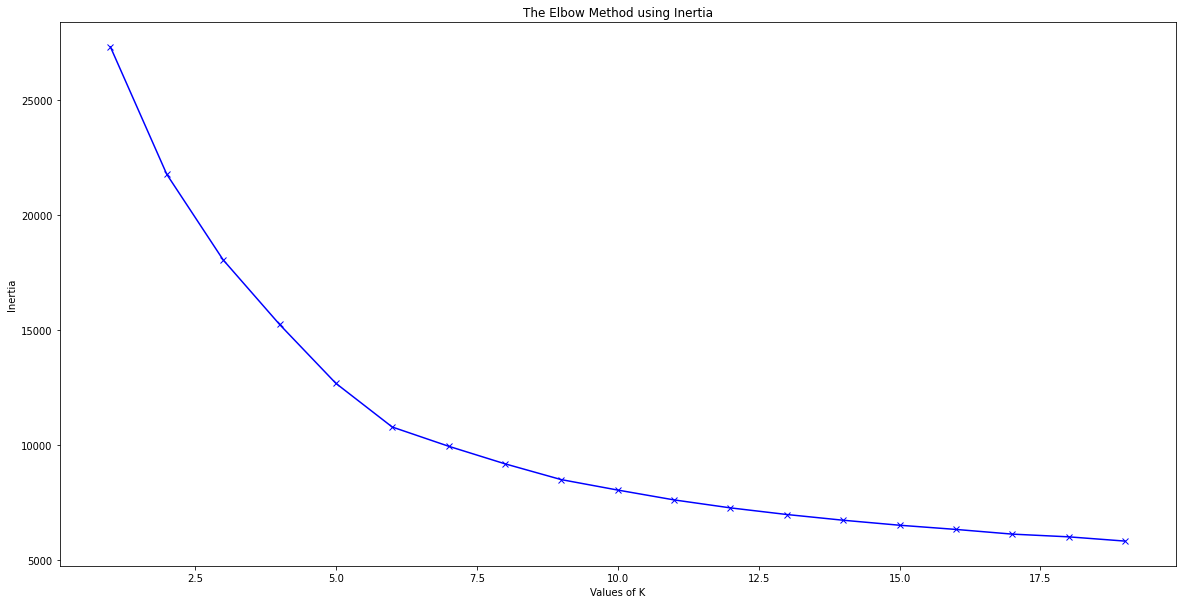

In [42]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Optimal no. of clusters = 6

### Step 3: Generate fingerprint database with structure {Loci(xi, yi), K-Means Cluster, Ftt}
- Use original fingerprint if do not plan to reduce the dimensions of each fingerprint

In [48]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(reduced_dims_features)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = {}
processed_fp_db['coords'] = labels
processed_fp_db['cluster_no'] = label_arr
processed_fp_db['fp'] = features

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 89628


### Step 4: Apply LSH algorithm for each of the clusters to hash fingerprints generated  and save the hash values in a data structure.

- Components of LSH algorithm
    - Stable distribution: Gaussian normal distribution with mean = 0 and variance = 1
    - dimension, d: Dimensions of the fingerprints with reduced dimensions, with shape of (1,16)
    - alpha, a: Vector of dimension d whose entry are chosen independently from the p-stable distribution.
    - vector v: Vector of dimension d that represents our fingerprint
    - r: Length of segment, by 'chopping' real line into eqi-distance segment of length r
    - b: A random number in the range of (0,r)